In [1]:
import os
import sys 
sys.path.append('../')
os.chdir('../')

In [2]:

import json
import time
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer, AutoModelForCausalLM
from transformers import GPT2LMHeadModel, GPT2Tokenizer
from transformers import LlamaTokenizer, LlamaForCausalLM
from transformers import pipeline
import torch
import re
import openai
# from tenacity import retry, wait_exponential, stop_after_attempt
from tqdm import tqdm
from dotenv import load_dotenv
import torch
import time
import json
from torch.utils.data import Dataset, DataLoader
from data.dataloader import get_dataloader
from argparse import ArgumentParser
import os
import pandas as pd 
import debugpy
from dotenv import load_dotenv

from trainer.transformer_utilts import *
%load_ext autoreload
%autoreload 2
import sys 
sys.path.append("..")
import pickle
from peft import get_peft_model
import json
from tqdm import tqdm
import openai
import pandas as pd
from data.dataloader import get_dataloader
from helper.dataloader import  map_id_to_title
import re
from torch.utils.data import DataLoader, Subset
import torch
import os
from dotenv import load_dotenv
from model.MF import sentenceT5Classification
import argparse
from torch.optim.lr_scheduler import LambdaLR
from helper.eval_metrics import *
from helper.dataloader import *
import wandb
from tqdm import tqdm
import math
from trainer.transformer_utilts import *
from torch.nn.parallel import DataParallel
from peft import LoraConfig, TaskType
from transformers import T5ForSequenceClassification
#import mp 
import torch.multiprocessing as mp
import torch.distributed as dist
from torch.utils.data.distributed import DistributedSampler
from torch.nn.parallel import DistributedDataParallel as DDP
import hashlib
from model.MF import sentenceT5Classification,sentenceT5ClassificationFrozen






args = parse_args(notebook=True)

debug_string  = "debug" if args.debug else ""
args.debug_prompts = True  
args.loss = 'bce_softmax'


rank = 0
world_size = 1


# setup(rank, world_size)



global_path = '/home/mila/e/emiliano.penaloza/LLM4REC'

args = parse_args(notebook=True)
load_dotenv()


tokenizer = AutoTokenizer.from_pretrained("t5-large")
prompts,rec_dataloader,num_movies,val_dataloader,test_dataloader,vad_data_tr,test_data_tr= load_data(args,tokenizer,rank,world_size)

path = f'{args.scratch}/saved_model/{args.data_name}/t5_classification_please_embedding_module_t5_classification_l2_lambda_0.01_lora_r_32_scheduler_cosine_warmup_0.001.csv.pt'
path = f'{args.scratch}/saved_model/{args.data_name}/t5_classification_embedding_module_t5_classification_l2_lambda_0.0001_lora_r_16_scheduler_cosine_warmup.csv.pt'
# path  = f'{args.scratch}/saved_model/{args.data_name}/t5_classification_embedding_module_t5_classification_l2_lambda_0.001_lora_r_16_scheduler_cosine_warmup_0.001_0.2.csv.pt'
# path = f'{args.scratch}/saved_model/{args.data_name}/t5_classification_please_embedding_module_t5_classification_l2_lambda_0.01_lora_r_32_scheduler_cosine_warmup_0.001.csv.pt'

#this is the best model
path = f'{args.scratch}/saved_model/{args.data_name}/t5_classification_please_embedding_module_t5_classification_l2_lambda_0.01_lora_r_32_scheduler_cosine_warmup_0.001.csv.pt'


model = sentenceT5Classification.from_pretrained('t5-large', num_labels=num_movies)

lora_config = LoraConfig(task_type=TaskType.SEQ_CLS, r=32, lora_alpha=16, lora_dropout=0,
                            target_modules=["q", "v"],
                            modules_to_save=['classification_head'])
model = get_peft_model(model, lora_config)


model.load_state_dict(torch.load(path ,map_location=torch.device('cuda')))
model.to(0)


with open('/home/mila/e/emiliano.penaloza/LLM4REC/vae/ml-1m/pro_sg_text/show2id.pkl','rb') as f:
    movie_id_map = pickle.load(f)
    #reverse the map
    movie_id_map = {v:k for k,v in movie_id_map.items()}
#reverse the map

movie_id_to_title = map_id_to_title('/home/mila/e/emiliano.penaloza/LLM4REC/data/ml-1m/movies.dat')
movie_id_to_genre = map_id_to_genre('/home/mila/e/emiliano.penaloza/LLM4REC/data/ml-1m/movies.dat')
#create a movie title to genre map
movie_title_to_genre = {movie_title: movie_id_to_genre[movie_id] for movie_id, movie_title in movie_id_to_title.items()}
 
for movie_id, genres in movie_title_to_genre.items():
    movie_title_to_genre[movie_id] = genres.split('|')

def tokenize_prompt(tokenizer,prompt,max_l):
    encodings = tokenizer([prompt],padding=True, truncation=True,max_length=max_l,
                          return_tensors='pt')

    return encodings

/home/mila/e/emiliano.penaloza/llm4rec/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


MODEL NAME = /home/mila/e/emiliano.penaloza/scratch/saved_model/ml-100k/Transformer/best_model_lr_0.0001_embedding_module_t5_epochs_3_l2_lambda_0.0001_lora_alpha_16_lora_r_16_bce_softmax__bias_False.pth
MODEL NAME = /home/mila/e/emiliano.penaloza/scratch/saved_model/ml-100k/Transformer/best_model_lr_0.0001_embedding_module_t5_epochs_3_l2_lambda_0.0001_lora_alpha_16_lora_r_16_bce_softmax__bias_False.pth


/home/mila/e/emiliano.penaloza/llm4rec/lib/python3.10/site-packages/transformers/models/t5/tokenization_t5_fast.py:158: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-large automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  warnings.warn(


Max Prompt Length 262
Number of Users is num_users=6016
Number of Movies is num_movies=3522
 len(self.indices)=5512
 len(self.indices)=250
 len(self.indices)=250


Some weights of sentenceT5Classification were not initialized from the model checkpoint at t5-large and are newly initialized: ['classification_head.dense.weight', 'classification_head.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/mila/e/emiliano.penaloza/LLM4REC/helper/dataloader.py:112: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  data = pd.read_csv(movies_file,sep="::",names=["movieId","title","genre"],encoding='ISO-8859-1')
/home/mila/e/emiliano.penaloza/LLM4REC/helper/dataloader.py:122: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specify

In [4]:


def get_dataloaders_simple(data,rank,world_size,bs,encodings,nonzer_indeces_train):
    rec_dataset =  DataMatrix(data,encodings,nonzer_indeces_train)
    rec_dataloader = DataLoader(rec_dataset, batch_size=bs, collate_fn= None , num_workers = 0,pin_memory=False,
                                shuffle=True) 
    return rec_dataloader



In [5]:

from helper.dataloader import DataMatrix,MatrixDataLoader


data_path = f'./data_preprocessed/{args.data_name}/'
    
loader = MatrixDataLoader(data_path)
train_data = loader.load_data('train')
vad_data_tr, vad_data_te = loader.load_data('validation')

args.bs = 250
#concat both the vad and test set 
valid_data =  vad_data_te

test_data_tr, test_data_te = loader.load_data('test')


test_data =   test_data_te

num_users = train_data.shape[0]
num_movies = train_data.shape[1]

nonzer_indeces_train = {i:v for i,v in enumerate(set(train_data.sum(axis =1 ).nonzero()[0]))}
nonzer_indeces_valid = {i:v for i,v in enumerate(set(valid_data.sum(axis =1 ).nonzero()[0]))}
nonzer_indeces_test = {i:v for i,v in enumerate(set(test_data.sum(axis = 1).nonzero()[0]))}



#pickle movie_id_map if it doesnt exist to saved_iser_summary 
with open ('/home/mila/e/emiliano.penaloza/LLM4REC/vae/ml-1m/pro_sg/profile2id.pkl','rb') as f:
    profile2id = pickle.load(f)

with open(f'./saved_user_summary/{args.data_name}/user_summary_gpt4_.json','r') as f:
    prompts = json.load(f)
    #make int 
prompts = {profile2id[int(float(k))]:v for k,v in prompts.items() } 

#sort prompt dict in ascending order 
promp_list = [v for k,v in prompts.items()]
max_l = max([len(i.split()) for i in promp_list])
print("Max Prompt Length",max_l)

encodings = {k: tokenizer([v],padding='max_length', return_tensors='pt',truncation=True,max_length=max_l) for k, v in sorted(prompts.items())} 
#squeze the encodings 
encodings = {k: {k1: v1.squeeze(0) for k1, v1 in v.items()} for k, v in encodings.items()}


print(f"Number of Users is {num_users=}")
print(f"Number of Movies is {num_movies=}")
rec_dataloader = get_dataloaders_simple(train_data,rank,world_size,args.bs,encodings,nonzer_indeces_train)
val_dataloader = get_dataloaders_simple(valid_data,rank,world_size,args.bs,encodings,nonzer_indeces_valid)
test_dataloader = get_dataloaders_simple(test_data,rank,world_size,args.bs,encodings,nonzer_indeces_test)


    

Max Prompt Length 262
Number of Users is num_users=6016
Number of Movies is num_movies=3522
 len(self.indices)=5512
 len(self.indices)=5512
 len(self.indices)=250
 len(self.indices)=250
 len(self.indices)=250
 len(self.indices)=250


In [78]:
train= train_data.toarray()
pop = train.sum(axis = 0)
pop = pop




In [7]:
#reverse profil2id
# id2profile = {v:k for k,v in profile2id.items()}
with open('/home/mila/e/emiliano.penaloza/LLM4REC/vae/ml-1m/pro_sg_text/profile2id.pkl','rb') as f:
    profile2id = pickle.load(f)
    #reverse the map
    id2profile = {v:k for k,v in profile2id.items()}
with open('/home/mila/e/emiliano.penaloza/LLM4REC/vae/ml-1m/pro_sg_text/show2id.pkl','rb') as f:
    movie_id_map = pickle.load(f)
    #reverse the map

    movie_id_map = {v:k for k,v in movie_id_map.items()}
movie_set = set([x for x in movie_id_map.keys()])

with open('/home/mila/e/emiliano.penaloza/LLM4REC/vae/ml-1m/pro_sg_text/profile2id.pkl','rb') as f:
    profile2id = pickle.load(f)
    #reverse the map
    id2profile = {v:k for k,v in profile2id.items()}


In [79]:

torch.cuda.set_device(rank)
metrics = defaultdict(list)
movie_set = set([x for x in movie_id_map.keys()])
user_id_set = set()
user_ids_l = []
lengths = []
u_ids_text = {}
model.to(rank)
torch.manual_seed(2024)
num_items = {}
pop_dict = {}

with torch.no_grad():
    model.eval()
    for b, item in enumerate(test_dataloader):
        user_ids = sum(item.pop('idx').cpu().tolist(), [])
        user_id_set.update(user_ids)
        item = {k: v.to(rank) for k, v in item.items()}
        movie_emb_clean = model(**item)[0]
        user_ids_l.append(user_ids)
        test_rows = test_data_tr[user_ids].toarray()
        test_rows_binary = test_rows.copy()
        test_rows_binary[np.where(test_rows > 0)] = 1
        movie_emb_clean[np.where(test_rows > 0)] = -torch.inf
        for i in range(len(user_ids)):
            user_id = id2profile[user_ids[i]]
            u_ids_text[user_id] = user_id
            pop_dict[user_id] = test_rows_binary[i] @ pop
            lengths.append(len(prompts[user_ids[i]].split()))


        labels = item['labels'].cpu().numpy()
        recon = movie_emb_clean.cpu().numpy()
        metrics['ndcgs_10'].append(NDCG_binary_at_k_batch(recon, labels, k=10).mean().tolist())
        metrics['ndcgs_20'].append(NDCG_binary_at_k_batch(recon, labels, k=20))
        metrics['ndcgs_50'].append(NDCG_binary_at_k_batch(recon, labels, k=50).mean().tolist())
        metrics['mrr@10'].append(MRR_at_k(recon, labels, k=10))
        metrics['mrr@20'].append(MRR_at_k(recon, labels, k=20))
        metrics['mrr@50'].append(MRR_at_k(recon, labels, k=50))
        metrics['rn_10_n'].append(Recall_at_k_batch(recon, labels, k=10))
        metrics['rn_20_n'].append(Recall_at_k_batch(recon, labels, k=20))
        metrics['rn_50_n'].append(Recall_at_k_batch(recon, labels, k=50))



 len(self.indices)=250
 len(self.indices)=250
 len(self.indices)=250


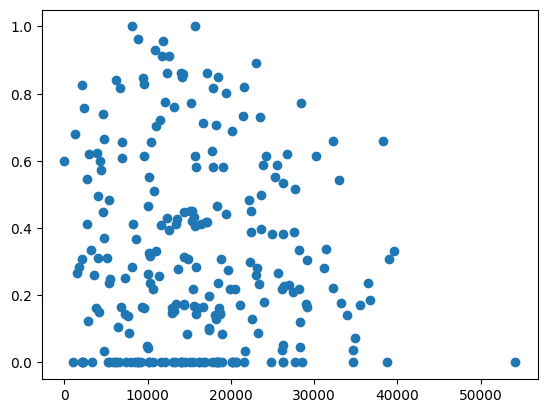

In [80]:
import matplotlib.pyplot as plt 
#flatten the user popularity into a list 
ndcg20 = metrics['ndcgs_20'][0].tolist()
pop_list = [v for k,v in pop_dict.items()]
#scatterplot 
plt.scatter(pop_list,ndcg20)

In [32]:

import json
import random 
import os
import pandas as pd
from scipy import sparse
import numpy as np
import pickle
import models
import torch.optim as optim
class DataLoaderAE():
    '''
    Load Movielens-20m dataset
    '''
    def __init__(self, path,k):
        self.pro_dir = os.path.join(path, f'pro_sg')
        assert os.path.exists(self.pro_dir), "Preprocessed files does not exist. Run data.py"

        self.n_items = self.load_n_items()
        self.k = k
    
    def load_data(self, datatype='train',original = False):
        if datatype == 'train':
            return self._load_train_data()
        elif datatype == 'validation':
            return self._load_tr_te_data(datatype)
        elif datatype == 'test':
            return self._load_tr_te_data(datatype,load_original=original)
        else:
            raise ValueError("datatype should be in [train, validation, test]")
        
    def load_n_items(self):
        unique_sid = list()
        with open(os.path.join(self.pro_dir, 'unique_sid.txt'), 'r') as f:
            for line in f:
                unique_sid.append(line.strip())
        n_items = len(unique_sid)
        return n_items
    
    def _load_train_data(self):
        path = os.path.join(self.pro_dir, 'train.csv')        
        tr_path = os.path.join(self.pro_dir, f'train_tr.csv')
        te_path = os.path.join(self.pro_dir, f'train_te.csv')

        
        tr = pd.read_csv(tr_path)
        tr_grouped = tr.groupby('uid').count()
        print(f"{tr_grouped=}")
        #get max count 
        max_count = tr_grouped.sid.max()
        assert max_count <= 50
        te = pd.read_csv(te_path)
        self.n_users = int(tr['uid'].max() + 1)


        rows, cols,ratings= tr['uid'], tr['sid'],tr['rating']

        data = sparse.csr_matrix((ratings,
                                 (rows, cols)), dtype='float64',
                                 shape=(self.n_users, self.n_items))
        
        rows, cols,ratings= te['uid'], te['sid'],te['rating']
        data_te = sparse.csr_matrix((np.ones_like(rows),
                                 (rows, cols)), dtype='float64',
                                 shape=(self.n_users, self.n_items))

        #binarize the data_te to be 1 if the rating is higher than 3 and 0 otherwise

        
        #assert that all rows are in data_te are bigger smaller than 1 
        assert data_te.max() <= 1,data_te.max()
        print('Number of users: {}, Number of items: {}'.format(self.n_users, self.n_items))
        data_te = data_te[data_te.sum(axis = 1).nonzero()[0]]
        data = data[data.sum(axis = 1).nonzero()[0]]
        #assert in each row of data ther are at most 50 nonzero elements
        for row in data: 
            assert len(row.nonzero()[1]) <= 50,len(row.nonzero()[1])
        return data,data_te
        
    def _load_tr_te_data(self, datatype='test',load_original = False):
        promt_dataset = pd.read_csv(f'./data_preprocessed/ml-1m/prompt_set_timestamped.csv')
        with open(os.path.join(self.pro_dir, 'show2id.pkl'), 'rb') as f:
            show2id = pickle.load(f)
            #reverse 
            id2show = {v:k for k,v in show2id.items()}
        with open(os.path.join(self.pro_dir,  'profile2id.pkl'), 'rb') as f:
            profile2id = pickle.load(f)
            #reverse
            id2profile = {v:k for k,v in profile2id.items()}
            
        
        tr_path = os.path.join(self.pro_dir, f'{datatype}_tr.csv')
        te_path = os.path.join(self.pro_dir, f'{datatype}_te.csv')
        if load_original:
            tr_path = '/home/mila/e/emiliano.penaloza/LLM4REC/vae/ml-1m/pro_sg/test_tr.csv'
            te_path = os.path.join('/home/mila/e/emiliano.penaloza/LLM4REC/vae/ml-1m/pro_sg', f'{datatype}_te.csv')

        tp_tr = pd.read_csv(tr_path)
        tp_te = pd.read_csv(te_path)
        #make sure all the users in tr are in te 
        tp_te = tp_te.loc[tp_te['uid'].isin(tp_tr['uid'])]
        #and viceversa
        tp_tr = tp_tr.loc[tp_tr['uid'].isin(tp_te['uid'])]

        start_idx = int(min(tp_tr['uid'].min(), tp_te['uid'].min()))
        end_idx = int(max(tp_tr['uid'].max(), tp_te['uid'].max()))

        rows_tr, cols_tr,rating_tr = tp_tr['uid'] - start_idx, tp_tr['sid'],tp_tr['rating']
        rows_te, cols_te,rating_te = tp_te['uid'] - start_idx, tp_te['sid'],tp_te['rating']

        data_tr = sparse.csr_matrix((rating_tr,
                                    (rows_tr, cols_tr)), dtype='float64', shape=(end_idx - start_idx + 1, self.n_items))
        # no need to make these the ratings as they are used for evaluation anyways
        data_te = sparse.csr_matrix((np.ones_like(rows_te),
                                    (rows_te, cols_te)), dtype='float64', shape=(end_idx - start_idx + 1, self.n_items))
        #make a map of user_id to row index
        #remove nonzero rows 
        user_id_to_row = {row_idx: user_id for row_idx, user_id in enumerate(tp_tr['uid'].unique())}
        data_te = data_te[data_te.sum(axis = 1).nonzero()[0]]
        data_tr = data_tr[data_tr.sum(axis = 1).nonzero()[0]]
        
        #assert the have the same dimensions 
        assert data_te.shape == data_tr.shape
        #assert data_tr has 50 nonzero rows for each user
        

        #assert all users in the user_id_row are in the prompt_dataset 
        for user_idx in user_id_to_row.values():
            user_id = id2profile[user_idx]
            if user_id not in promt_dataset.userId.unique():
                print(f"{user_id=}")
                print(f"{promt_dataset.userId.unique()=}")
                raise AssertionError("Not all users in the user_id_row are in the prompt_dataset")

        #assert that tr only has 50 movies 
        if datatype != 'train':
            for row_idx in range(data_tr.shape[0]):
                if len(data_tr[row_idx].nonzero()[1]) > 50:
                    print(f"{len(data_tr[row_idx].nonzero()[1])=}")
                    print(f"{data_tr[row_idx].nonzero()[1]=}")
                    print(f"{row_idx=}")
                    raise ValueError("data_tr has more than 50 nonzero rows for a user")
            

        return data_tr, data_te,user_id_to_row


k =50
device = torch.device("cuda" )
with open (f'/home/mila/e/emiliano.penaloza/LLM4REC/vae/ml-1m/pro_sg/profile2id.pkl','rb') as f:
    profile2id = pickle.load(f)
    #reverse the pfogile2id
    id2profile = {v:k for k,v in profile2id.items()}
with open(f'/home/mila/e/emiliano.penaloza/LLM4REC/vae/ml-1m/pro_sg/show2id.pkl','rb') as f:
    movie_id_map = pickle.load(f)
    #reverse the map
    movie_id_map = {v:k for k,v in movie_id_map.items()}
    movie_set = set(movie_id_map.keys())

###############################################################################
# Load data
###############################################################################

loader = DataLoaderAE('/home/mila/e/emiliano.penaloza/LLM4REC/vae/ml-1m',k)

n_items = loader.load_n_items()
# ae_train_data_tr,ae_train_data_te = loader.load_data('train')
# vad_data_tr, vad_data_te,user_id_to_row_val = loader.load_data('validation')

ae_test_data_tr, ae_test_data_te,user_id_to_row_test = loader.load_data('test')
ae_test_data_tr_original,_,_ = loader.load_data('test',original = True)

N = 6013

idxlist = list(range(N))



###############################################################################
# Build the model
###############################################################################

p_dims = [200, n_items]
model_vae = models.MultiDAE(p_dims).to(device)


optimizer = optim.Adam(model.parameters(), lr=args.lr , weight_decay=args.wd)
criterion = models.loss_function
prompt_set_df = pd.read_csv(f'/home/mila/e/emiliano.penaloza/LLM4REC/data_preprocessed/ml-1m/prompt_set_timestamped.csv')
prompt_set_df = prompt_set_df[prompt_set_df.rating > 3]
df = pd.read_csv('/home/mila/e/emiliano.penaloza/LLM4REC/data_preprocessed/ml-1m/strong_generalization_set_timestamped.csv')
df = df[df.rating > 3]
###############################################################################
# Training code
###############################################################################

# TensorboardX Writer


def sparse2torch_sparse(data):
    """
    Convert scipy sparse matrix to torch sparse tensor with L2 Normalization
    This is much faster than naive use of torch.FloatTensor(data.toarray())
    https://discuss.pytorch.org/t/sparse-tensor-use-cases/22047/2
    """
    samples = data.shape[0]
    features = data.shape[1]
    coo_data = data.tocoo()
    indices = torch.LongTensor([coo_data.row, coo_data.col])
    row_norms_inv = 1 / np.sqrt(data.sum(1))
    row2val = {i : row_norms_inv[i].item() for i in range(samples)}
    values = np.array([row2val[r] for r in coo_data.row])
    t = torch.sparse.FloatTensor(indices, torch.from_numpy(values).float(), [samples, features])
    return t

def naive_sparse2tensor(data):
    #if dat ais numpy asrray 
    if isinstance(data,np.ndarray):
        return torch.FloatTensor(data)
    return torch.FloatTensor(data.toarray())



In [40]:
ae_test_data_te_arr = ae_test_data_te.toarray()
ae_test_data_te_binarized = (ae_test_data_te_arr > 0).astype(int)


ae_test_data_tr_arr = ae_test_data_tr.toarray()
ae_test_data_tr_binarized = (ae_test_data_tr_arr > 0).astype(int)

#get the subset for ae_test_data_te and ae_test_data_tr where they have more than 

ae_test_data_tr_binarized.sum(axis = 1),ae_test_data_te_arr.shape

(array([50, 50, 38, 50, 37, 46, 50, 18, 50, 50, 26, 50, 50, 50, 50, 50, 49,
        50, 45, 50, 50, 50, 50, 23, 27, 19, 23, 50, 50, 36, 50, 50, 36, 50,
        50, 50, 50, 50, 24, 46, 50, 50, 24, 50, 50, 32, 50, 23, 27, 50, 50,
        20, 47, 50, 39, 39, 50, 50, 50, 50, 50, 49, 50, 50, 50, 22, 27, 50,
        50, 50, 50, 50, 49, 50, 50, 50, 50, 50, 50, 50, 37, 46, 43, 50, 50,
        50, 24, 38, 50, 22, 50, 50, 50, 50, 50, 50, 22, 50, 50, 32, 23, 50,
        21, 50, 50, 28, 50, 50, 50, 50, 50, 35, 50, 50, 50, 50, 50, 24, 50,
        50, 23, 20, 50, 41, 50, 50, 33, 50, 50, 21, 28, 50, 44, 50, 50, 19,
        50, 50, 50, 50, 22, 25, 50, 35, 50, 28, 38, 22, 50, 50, 44, 49, 19,
        50, 50, 50, 48, 50, 50, 49, 50, 50, 50, 50, 33, 31, 50, 50, 50, 50,
        50, 50, 50, 50, 50, 26, 50, 50, 23, 26, 50, 50, 50, 50, 20, 18, 50,
        50, 50, 27, 50, 50, 49, 50, 50, 50, 50, 18, 24, 50, 25, 50, 30, 50,
        50, 50, 50, 50, 50, 50, 46, 50, 29, 26, 34, 50, 50, 50, 50, 41, 50,
        50, 

In [48]:
ae_test_data_te_arr.sum(axis = 1)

array([157.,  16.,   2.,  67.,   2.,   2.,  16.,   2., 219.,  14.,   2.,
       133.,  26.,  28.,   8.,  23.,   2.,  95.,   2.,   8.,  86., 304.,
        40.,   2.,   2.,   2.,   2.,  22., 100.,   2.,  53., 330.,   2.,
        76.,  70.,  18., 281.,  10.,   2.,   2., 126.,   5.,   2.,  57.,
       140.,   2., 143.,   2.,   2., 284., 225.,   2.,   2.,  13.,   2.,
         2., 242.,  13.,  64.,  80., 134., 361.,  93., 419., 170.,   2.,
         2., 173.,  16., 302.,  48., 193., 175.,  12.,  33., 269.,  23.,
        36.,   2.,  25.,   2.,   2.,   2.,  89., 383.,  16.,   2.,   2.,
        33.,   2.,  26., 390.,  33.,   4.,  56.,  35.,   2.,  61., 103.,
         2.,   2.,   3.,   2.,  51.,  89.,   2., 121.,   9.,  15.,  78.,
       238.,   2.,  55.,  10.,  14.,  40.,  25.,   2., 162.,  14.,   2.,
         2.,  15.,   2.,  33.,  59.,   2.,  52.,   7.,   2.,   2., 258.,
         2., 110.,  17.,   2., 101.,  10.,  18.,  51.,   2.,   2., 133.,
         2., 198.,   2.,   2.,   2.,  41.,  20.,   

In [41]:

with open('/home/mila/e/emiliano.penaloza/LLM4REC/vae/model_all_DAE.pt', 'rb') as f:
    model_vae= torch.load(f)
    model_vae.to(device)


    model.eval()

In [69]:
from collections import defaultdict

def evaluate(data_tr, data_te, model):
    # Turn on evaluation mode
    model.eval()
    metrics = defaultdict(list)
    total_loss = []
    global update_count
    e_idxlist = list(range(data_tr.shape[0]))
    e_N = data_tr.shape[0]

    with torch.no_grad():
        # for start_idx in range(0, e_N, args.batch_size):
            # end_idx = min(start_idx + args.batch_size, N)
            data = data_tr
            data_tr_binarized = (data > 0).astype('float32')

            heldout_data = data_te 
            
            data_tensor = naive_sparse2tensor(data).to(device)

            anneal = 0
            recon_batch, mu, logvar = model(data_tensor)
            loss = criterion(recon_batch, data_tensor, mu, logvar, anneal)
            recon_batch = recon_batch.cpu().numpy()
            recon_batch[ae_test_data_tr_original.nonzero()] = -np.inf
            heldout_data = heldout_data.toarray()
            
            
            mrr10 = MRR_at_k(recon_batch, heldout_data, 10)
            mrr20 = MRR_at_k(recon_batch, heldout_data, 20)
            mrr50 = MRR_at_k(recon_batch, heldout_data, 50)
            n10 = NDCG_binary_at_k_batch(recon_batch, heldout_data,10).mean()
            n20 = NDCG_binary_at_k_batch(recon_batch, heldout_data,20)
            n20_no_mean = Recall_at_k_batch(recon_batch, heldout_data,50).mean()
            n50 = NDCG_binary_at_k_batch(recon_batch, heldout_data,50).mean()

            r10 = Recall_at_k_batch(recon_batch, heldout_data,10)
            r20 = Recall_at_k_batch(recon_batch, heldout_data,20)
            r50 = Recall_at_k_batch(recon_batch, heldout_data,50)

            # for j,i in enumerate(e_idxlist[start_idx:end_idx]):
            #     idx = user_id_to_row_test[i]
            #     user_id = id2profile[idx]
            metrics['mrr10'].append(mrr10)
            metrics['mrr20'].append(mrr20)
            metrics['mrr50'].append(mrr50)
            metrics['n10'].append(n10)
            metrics['n20'].append(n20)
            metrics['n50'].append(n50)
            # metrics['map10'].append(map10)
            # metrics['map20'].append(map20)
            # metrics['map50'].append(map50)
            metrics['rn10'].append(r10)
            metrics['rn20'].append(r20)
            metrics['rn50'].append(r50)

            # metrics['r10_u'].append(r10_u)
            # metrics['r20_u'].append(r20_u)
            # metrics['r50_u'].append(r50_u)
    n20_out = {}
    for i in e_idxlist:
        if i in user_id_to_row_test:
            idx = user_id_to_row_test[i] 
            user_id = id2profile[idx]
            n20_out[user_id] = n20[i]
        else: continue



    return metrics,n20_out

In [70]:
ae_metrics,n20 = evaluate(ae_test_data_tr, ae_test_data_te,model_vae)
print(f"{ae_test_data_tr.shape=}")



ae_test_data_tr.shape=(250, 3522)


In [72]:
np.mean([v for v in n20.values()])

0.3391061683543277

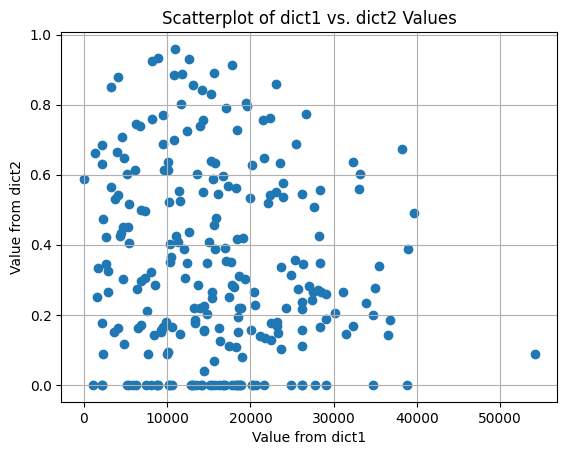

In [81]:
import matplotlib.pyplot as plt

# Example dictionaries
dict1 = pop_dict
dict2 = n20


# Ensure both dicts have the same keys
keys1 = set(dict1.keys())
keys2 = set(dict2.keys())
common_keys = keys1.intersection(keys2)

# Extract the values in an aligned manner
x_values = [dict1[key] for key in common_keys]
y_values = [dict2[key] for key in common_keys]

# Plot
plt.scatter(x_values, y_values)
# for i, key in enumerate(common_keys):
#     plt.text(x_values[i], y_values[i], key)  # Optionally, annotate each point with its userid

plt.xlabel('Value from dict1')
plt.ylabel('Value from dict2')
plt.title('Scatterplot of dict1 vs. dict2 Values')
plt.grid(True)
plt.show()
